In [1]:
from ucsgnet.ucsgnet.net_3d import Net

import torch
import shlex
import argparse
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from collections import defaultdict

In [2]:
def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser(
        description=(
            "Reconstructs all shapes in the dataset by predicting values at "
            "each 3D point and then thresholding"
        ),
        add_help=False,
    )

    parser.add_argument(
        "--weights_path", required=True, help="Path to the model to load"
    )
    parser.add_argument(
        "--size", type=int, help="Data size to be used", required=True
    )
    parser.add_argument(
        "--processed",
        dest="processed_data_path",
        type=str,
        help="Base folder of processed data",
        required=True,
    )
    parser.add_argument(
        "--valid",
        dest="valid_file",
        type=str,
        help="Path to valid HDF5 file with the valid data",
        required=True,
    )
    parser.add_argument(
        "--valid_shape_names",
        type=str,
        help=(
            "Path to valid text file with the names for each data point in "
            "the valid dataset"
        ),
        required=True,
    )
    parser.add_argument(
        "--sphere_complexity",
        type=int,
        help="Number of segments lat/lon of the sphere",
        required=False,
        default=16,
    )

    parser = Net.add_model_specific_args(parser)
    args = parser.parse_args(
        shlex.split(
            "--valid all_vox256_img_test.hdf5 --valid_shape_names all_vox256_img_test.txt --processed data/hdf5 --size 64 --weights_path models/3d_64/initial/ckpts/model.ckpt --sphere_complexity 3"
        )
    )
    return args

args = get_args()

In [3]:
model = Net.load_from_checkpoint(args.weights_path)
model.build("", args.valid_file, args.processed_data_path, 64)
model.turn_fine_tuning_mode()
model.freeze()
model.hparams.batch_size = 12
if torch.cuda.is_available():
    model = model.cuda()
with open(
    os.path.join(args.processed_data_path, args.valid_shape_names)
) as f:
    file_names = f.read().split("\n")

loader = model.val_dataloader()

Num of trainable params: 16641062
Num of not trainable params: 0


In [4]:
device = next(model.parameters()).device
latents = []
latent_codes_for_samples = defaultdict(list)
emits = defaultdict(list)
for _, batch in enumerate(tqdm(loader)):
    voxels = batch[0].to(device)
    points = batch[1].to(device)
    vox_pred = (
        model.net.encoder_(voxels)
    )
    
    latent_codes, batch_emits = model.net.get_latent_codes_for_each_layer(
        voxels, points
    )
    for key, elems in latent_codes.items():
        latent_codes_for_samples[key].append(elems)
        
    for key, elems in batch_emits.items():
        emits[key].append(elems)
    latents.append(vox_pred)
latents = torch.cat(latents, dim=0).detach().cpu().numpy()
latent_codes_for_samples = {key: torch.cat(lats, dim=0).detach().cpu().numpy() for key, lats in latent_codes_for_samples.items()}
emits = {key: torch.cat(lats, dim=0).detach().cpu().numpy() for key, lats in emits.items()}

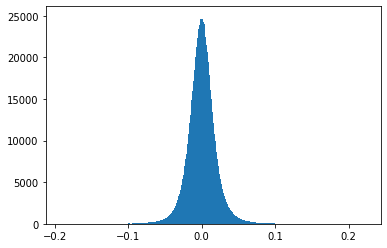

In [5]:
plt.hist(latents.reshape((-1,)), bins=1000)
print()

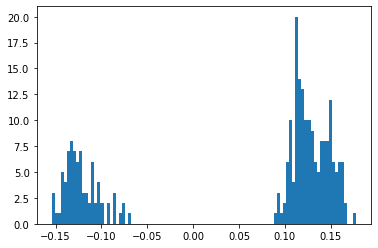

In [6]:
plt.hist(model.net._gru_hidden_state.detach().cpu().numpy()[0], bins=100)
print()

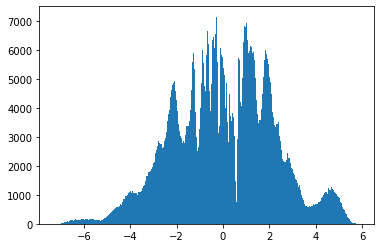

In [12]:
plt.hist(emits['emits_3'].reshape((-1,)), bins=1000)
print()

In [ ]:
tsne = TSemitscomponents=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(latents)

In [ ]:
cat_to_str = {name.split("_")[0]: name.split("_")[1] for name in [
    "02691156_airplane",
    "02828884_bench",
    "02933112_cabinet",
    "02958343_car",
    "03001627_chair",
    "03211117_display",
    "03636649_lamp",
    "03691459_speaker",
    "04090263_rifle",
    "04256520_couch",
    "04379243_table",
    "04401088_phone",
    "04530566_vessel",
]}

In [ ]:
data = {}
data['y'] = tsne_results[:,0]
data['x'] = tsne_results[:,1]
classes = [cat_to_str[name.split('/')[0]] for name in file_names[:-1]]
data["Object"] = classes
data = pd.DataFrame(data)
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="x", y="y",
    hue="Object",
    palette=sns.color_palette("hls", 13),
    data=data,
    legend="full",
    alpha=0.3
)
ax.set_ylabel("off")

In [ ]:
data['y']